In [551]:
import json
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0,'/media/csivsw/crossOS/playground/friends_of_tracking/src/friends_of_tracking/LaurieOnTracking')
%matplotlib inline

In [552]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel

In [553]:
# set up initial path to data
DATADIR = '../datahub/metrica_sports/sample-data/data'
game_id = 2 # let's look at sample match 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)


Reading team: home
Reading team: away


In [554]:
# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe8853f6cc0>)

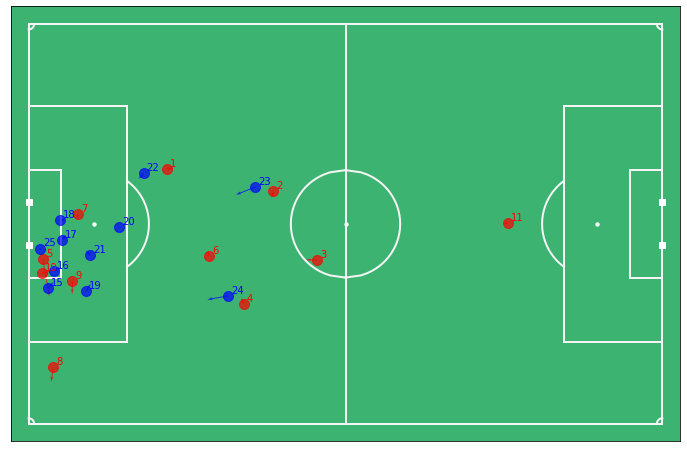

In [555]:
# plot a random frame, plotting the player velocities using quivers
mviz.plot_frame( tracking_home.loc[10000], tracking_away.loc[10000], include_player_velocities=True, annotate=True)


In [556]:
# Create a Physical summary dataframe for home players
home_players = np.unique( [ c.split('_')[1] for c in tracking_home.columns if c[:4] == 'Home' ] )
home_summary = pd.DataFrame(index=home_players)

In [557]:
# Calculate minutes played for each player
minutes = []
for player in home_players:
    # search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Home_' + player + '_x' # use player x-position coordinate
    player_minutes = ( tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1 ) / 25 / 60. # convert to minutes
    minutes.append( player_minutes )
home_summary['Minutes Played'] = minutes
home_summary = home_summary.sort_values(['Minutes Played'], ascending=False)

In [558]:
# Calculate total distance covered for each player
distance = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_distance = tracking_home[column].sum()/25./1000 # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance.append( player_distance )
home_summary['Distance [km]'] = distance

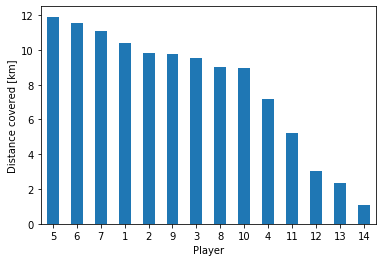

In [559]:
# make a simple bar chart of distance covered for each player
plt.subplots()
ax = home_summary['Distance [km]'].sort_values(ascending=False).plot.bar(rot=0);
ax.set_xlabel('Player');
ax.set_ylabel('Distance covered [km]');

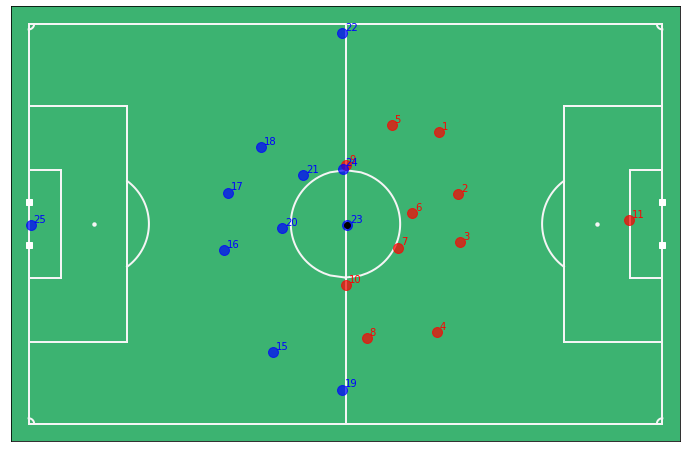

In [560]:
# plot positions at KO (to find out what position each player is playing)
mviz.plot_frame(tracking_home.loc[51], 
                tracking_away.loc[51], 
                include_player_velocities=False, annotate=True);


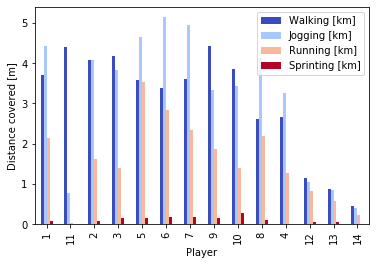

In [561]:
# now calculate distance covered while: walking, joggings, running, sprinting
walking = []
jogging = []
running = []
sprinting = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_home.loc[tracking_home[column] < 2, column].sum()/25./1000
    walking.append( player_distance )
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 2) & (tracking_home[column] < 4), column].sum()/25./1000
    jogging.append( player_distance )
    # running (between 4 and 7 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 4) & (tracking_home[column] < 7), column].sum()/25./1000
    running.append( player_distance )
    # sprinting (greater than 7 m/s)
    player_distance = tracking_home.loc[ tracking_home[column] >= 7, column].sum()/25./1000
    sprinting.append( player_distance )
    
home_summary['Walking [km]'] = walking
home_summary['Jogging [km]'] = jogging
home_summary['Running [km]'] = running
home_summary['Sprinting [km]'] = sprinting

# make a clustered bar chart of distance covered for each player at each speed
ax = home_summary[['Walking [km]','Jogging [km]',
                   'Running [km]','Sprinting [km]']].plot.bar(colormap='coolwarm')
ax.set_xlabel('Player');
ax.set_ylabel('Distance covered [m]');

In [562]:
# sustained sprints: how many sustained sprints per match did each player complete? Defined as maintaining a speed > 7 m/s for at least 1 second
nsprints = []
sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # trick here is to convolve speed with a window of size 'sprint_window', and find number of occassions that sprint was sustained for at least one window length
    # diff helps us to identify when the window starts
    player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
    nsprints.append( np.sum( player_sprints == 1 ) )
home_summary['# sprints'] = nsprints

In [563]:
home_summary.head()

,Minutes Played,Distance [km],Walking [km],Jogging [km],Running [km],Sprinting [km],# sprints
1,94.104,10.369966,3.701953,4.436083,2.149219,0.082712,5
11,94.104,5.203820,4.394682,0.777765,0.029655,0.001718,0
2,94.104,9.845300,4.085937,4.066061,1.612491,0.080811,3
3,94.104,9.546312,4.178461,3.832849,1.382836,0.152166,8
5,94.104,11.909182,3.583949,4.652462,3.519102,0.153669,8


In [564]:
# Plot the trajectories for each of player 10's sprints
player = '10'
column = 'Home_' + player + '_speed' # spped
column_x = 'Home_' + player + '_x' # x position
column_y = 'Home_' + player + '_y' # y position

In [565]:
# same trick as before to find start and end indices of windows of size 'sprint_window' in which player speed was above the sprint_threshold
player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), 
                                          np.ones(sprint_window), mode='same' ) >= sprint_window ) )
player_sprints_start = np.where( player_sprints == 1 )[0] - int(sprint_window/2) + 1 # adding sprint_window/2 because of the way that the convolution is centred
player_sprints_end = np.where( player_sprints == -1 )[0] + int(sprint_window/2) + 1
list(zip(player_sprints_start,player_sprints_end))

[(16301, 16436),
 (20977, 21018),
 (34805, 34846),
 (37380, 37467),
 (51704, 51796),
 (61245, 61294),
 (73660, 73703),
 (81180, 81220),
 (83622, 83677),
 (89387, 89427),
 (104002, 104049),
 (109524, 109553),
 (124176, 124259)]

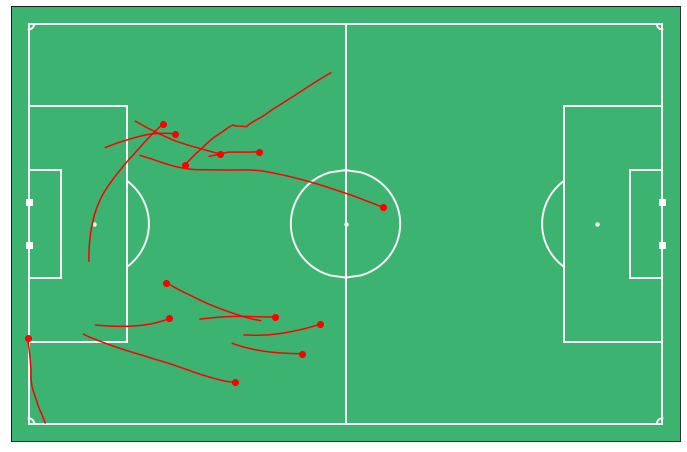

In [566]:
# now plot all the sprints
fig,ax = mviz.plot_pitch()
for s,e in zip(player_sprints_start,player_sprints_end):
    ax.plot(tracking_home[column_x].iloc[s],tracking_home[column_y].iloc[s],'ro')
    ax.plot(tracking_home[column_x].iloc[s:e+1],tracking_home[column_y].iloc[s:e+1],'r')
    
# END

# Homework

# Estimate the top speed of each player

In [567]:
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_top_speed = tracking_home[column].max()
    print (player, player_top_speed)
#     tracking_home[column].plot.kde()
#     break
#     print (tracking_home[column].sort_values(ascending=False).head(10))

# get variance in rolling window of 25 frames = 1 second
# weight each frame's speed by the second's variance
# get the top speed

# or

# get 1 sec var
# find least var -> get the window -> avg the speed in it


1 10.4897777016299
11 9.953194587157043
2 9.440066226843154
3 10.250773004211188
5 11.039275727906388
6 9.492949753391231
7 8.624471739212717
9 9.250738425022002
10 10.2882221885508
8 11.115749639184966
4 10.584900686885275
12 10.431468726944377
13 8.843431683397448
14 9.809842211200976


In [205]:
for player in home_summary.index:
    speed_column = 'Home_' + player + '_speed'
    mean_column = 'Home_' + player + '_mean'
    var_column = 'Home_' + player + '_variance'
    weighted_speed_column = 'Home_' + player + '_weighted_speed'
    
    player_top_speed = tracking_home[speed_column].max()
    print (player, player_top_speed)

    tracking_home[mean_column] = tracking_home[speed_column].rolling(25).mean()
    tracking_home[var_column] = tracking_home[speed_column].rolling(25).var()
    
    tracking_home[weighted_speed_column] = tracking_home[speed_column]*tracking_home[var_column]
    print (tracking_home[[speed_column,mean_column,
                          var_column,
                          weighted_speed_column]].sort_values([weighted_speed_column], 
                                                                     ascending=False).head(5))


1 10.4897777016299
       Home_1_speed  Home_1_mean  Home_1_variance  Home_1_weighted_speed
Frame                                                                   
17579      8.678225     4.177126         4.673486              40.557567
17578     10.489778     4.006042         3.800925              39.870861
53438      8.386478     2.119490         4.442793              37.259389
17580      7.096880     4.284300         5.014320              35.586028
53439      6.540898     2.333257         5.174247              33.844224
11 9.953194587157043
       Home_11_speed  Home_11_mean  Home_11_variance  Home_11_weighted_speed
Frame                                                                       
36140       8.696793      3.296696          8.361387               72.717245
36139       9.953195      2.996829          7.235828               72.019606
36141       7.561812      3.545853          8.893999               67.254745
36142       5.620326      3.712272          8.863151            

In [250]:
# plot cumulative distance
tracking_home.head()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_6_speed,Home_7_vx,Home_7_vy,Home_7_speed,Home_8_vx,Home_8_vy,Home_8_speed,Home_9_vx,Home_9_vy,Home_9_speed
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,46.9315,-0.28084,15.70072,14.5486,18.81712,4.89396,21.07492,-3.81208,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [227]:
tracking_home_dists = tracking_home.diff()
tracking_home_dists.iloc[:,:2] = tracking_home.iloc[:,:2]
for i in range(1,12):
    tracking_home_dists['Home_{}_d'.format(i)] = np.sqrt((tracking_home_dists['Home_{}_x'.format(i)] ** 2)+\
                                             (tracking_home_dists['Home_{}_y'.format(i)] ** 2))

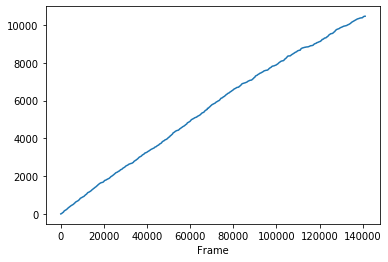

In [231]:
tracking_home_dists.Home_1_d.cumsum().plot()

In [238]:
tracking_home_dists.Home_10_d.dropna()[10:]/0.04

Frame
12        1.242131
13        0.935375
14        1.112916
15        0.682062
16        0.646543
            ...   
125734    0.607546
125735    0.693310
125736    0.873675
125737    0.973345
125738    1.134420
Name: Home_10_d, Length: 125727, dtype: float64

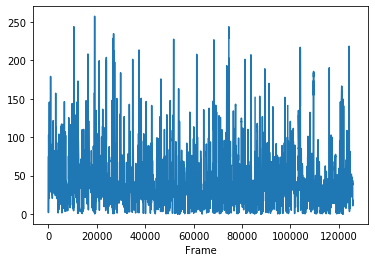

In [244]:
(tracking_home.Home_10_speed/0.04).plot()

# Measure player acceleration from the tracking data and estimate the maximum rate of acceleration for each player

In [568]:
import numpy as np
import scipy.signal as signal

def calc_player_accelerations(team, 
                              smoothing=True,
                              filter_='Savitzky-Golay',
                              window=7, polyorder=1, maxspeed = 12):
    """ calc_player_velocities( tracking_data )
    
    Calculate player velocities in x & y direciton, and total player speed at each timestamp of the tracking data
    
    Parameters
    -----------
        team: the tracking DataFrame for home or away team
        smoothing: boolean variable that determines whether velocity measures are smoothed. Default is True.
        filter: type of filter to use when smoothing the velocities. Default is Savitzky-Golay, which fits a polynomial of order 'polyorder' to the data within each window
        window: smoothing window size in # of frames
        polyorder: order of the polynomial for the Savitzky-Golay filter. Default is 1 - a linear fit to the velcoity, so gradient is the acceleration
        maxspeed: the maximum speed that a player can realisitically achieve (in meters/second). Speed measures that exceed maxspeed are tagged as outliers and set to NaN. 
        
    Returrns
    -----------
       team : the tracking DataFrame with columns for speed in the x & y direction and total speed added

    """
    # remove any velocity data already in the dataframe
#     team = remove_player_velocities(team)
    
    # Get the player ids
    player_ids = np.unique( [ c.split('_')[:2] for c in team.columns if c[:4] in ['Home','Away'] ] )
    print (player_ids)
    # Calculate the timestep from one frame to the next. Should always be 0.04 within the same half
    dt = team['Time [s]'].diff()
    
    # index of first frame in second half
    second_half_idx = team.Period.idxmax(2)
    
    # estimate velocities for players in team
    for player in player_ids[:-1]: # cycle through players individually
        player = player_ids[-1]+'_'+player
        # difference player positions in timestep dt to get unsmoothed estimate of velicity
        ax = team[player+"_vx"].diff() / dt
        ay = team[player+"_vy"].diff() / dt

        if maxspeed>0:
            # remove unsmoothed data points that exceed the maximum speed (these are most likely position errors)
            raw_acc = np.sqrt( ax.values**2 + ay.values**2 )
#             ax.values[raw_acc>maxspeed] = np.nan
#             ay.values[raw_acc>maxspeed] = np.nan
            
        if smoothing:
            # calculate first half velocity
            ax.loc[:second_half_idx] = signal.savgol_filter(ax.loc[:second_half_idx],window_length=window,polyorder=polyorder)
            ay.loc[:second_half_idx] = signal.savgol_filter(ay.loc[:second_half_idx],window_length=window,polyorder=polyorder)        
            # calculate second half velocity
            ax.loc[second_half_idx:] = signal.savgol_filter(ax.loc[second_half_idx:],window_length=window,polyorder=polyorder)
            ay.loc[second_half_idx:] = signal.savgol_filter(ay.loc[second_half_idx:],window_length=window,polyorder=polyorder)
        
        # put player speed in x,y direction, and total speed back in the data frame
        team[player + "_ax"] = ax
        team[player + "_ay"] = ay
        team[player + "_acc"] = np.sqrt( ax**2 + ay**2 )

    return team

In [569]:
# Calculate player accelerations
tracking_home = calc_player_accelerations(tracking_home,smoothing=True)
tracking_away = calc_player_accelerations(tracking_away,smoothing=True)

['1' '10' '11' '12' '13' '14' '2' '3' '4' '5' '6' '7' '8' '9' 'Home']
['15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' 'Away']


In [272]:
tracking_home[['Time [s]','Home_10_x','Home_10_y',
               'Home_10_vx','Home_10_vy','Home_10_speed',
               'Home_10_ax','Home_10_ay','Home_10_acc']]

,Time [s],Home_10_x,Home_10_y,Home_10_vx,Home_10_vy,Home_10_speed,Home_10_ax,Home_10_ay,Home_10_acc
Frame,,,,,,,,,
15,0.60,0.04664,-10.43596,-0.026500,-0.806286,0.806721,0.621939,8.803571,8.825513
16,0.64,0.04770,-10.46180,-0.015143,-0.682429,0.682597,0.486735,4.622959,4.648512
17,0.68,0.04770,-10.48084,-0.015143,-0.612000,0.612187,0.324490,3.165816,3.182403
18,0.72,0.04770,-10.50328,0.007571,-0.490571,0.490630,0.216327,2.515306,2.524591
19,0.76,0.04876,-10.51824,0.026500,-0.408000,0.408860,0.283929,2.324490,2.341766
...,...,...,...,...,...,...,...,...,...
125728,5029.12,-0.03710,34.14212,0.333143,0.422571,0.538099,0.689541,-1.838776,1.963813
125729,5029.16,-0.02226,34.15640,0.359643,0.335143,0.491593,0.689541,-2.211735,2.316730
125730,5029.20,-0.00636,34.16864,0.386143,0.221000,0.444913,0.648980,-2.628061,2.707006


In [275]:
(tracking_home['Home_10_acc'].diff()/0.04).max()

324.26847700430034

In [570]:
import seaborn as sns
import re
import matplotlib.ticker as ticker

In [432]:
hm_data = tracking_home[[c for c in tracking_home.columns if 'speed' in c]].reset_index()
hm_data['mins'] = round(tracking_home['Time [s]']/60)
hm_data = hm_data.T

In [306]:
hm_data = tracking_home[[c for c in tracking_home.columns if 'speed' in c]].T
hm_data.columns = round(tracking_home['Time [s]']/60)

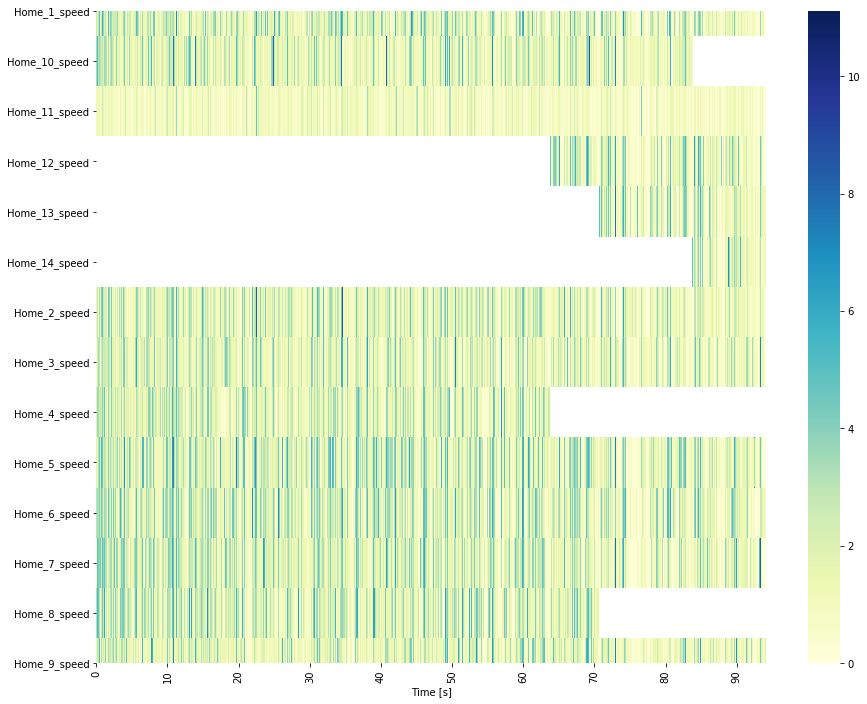

In [418]:
fig, ax = plt.subplots(figsize=(15,12))

g = sns.heatmap(hm_data, cmap='YlGnBu')
g.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
g.xaxis.set_major_locator(ticker.MultipleLocator(base=25*60*10)) #25 frames * 60 sec * 10 mins
g.set_xticklabels([0,0,10,20,30,40,50,60,70,80,90]);

In [550]:
hm_data.max(axis=1)
hm_data.iloc[:,16436]
hm_data.loc['Home_12_speed'].dropna()
hm_data.loc['Home_12_speed'].argmax()
hm_data.loc['Home_12_speed'][112149]

KeyError: 'Home_12_speed'

In [571]:
speed_cols = [c for c in tracking_home.columns if 'speed' in c]
acc_cols = [c for c in tracking_home.columns if 'acc' in c]
home_players = [re.findall('\d+',x)[0] for x in speed_cols]
cols = []
for player_num in home_players:
    cols.append([x for x in speed_cols if '_{}_'.format(player_num) in x][0])
    cols.append([x for x in acc_cols if '_{}_'.format(player_num) in x][0])
cols    

hm_data = tracking_home[cols].reset_index()
hm_data['mins'] = round(tracking_home['Time [s]']/60)
hm_data = hm_data.T

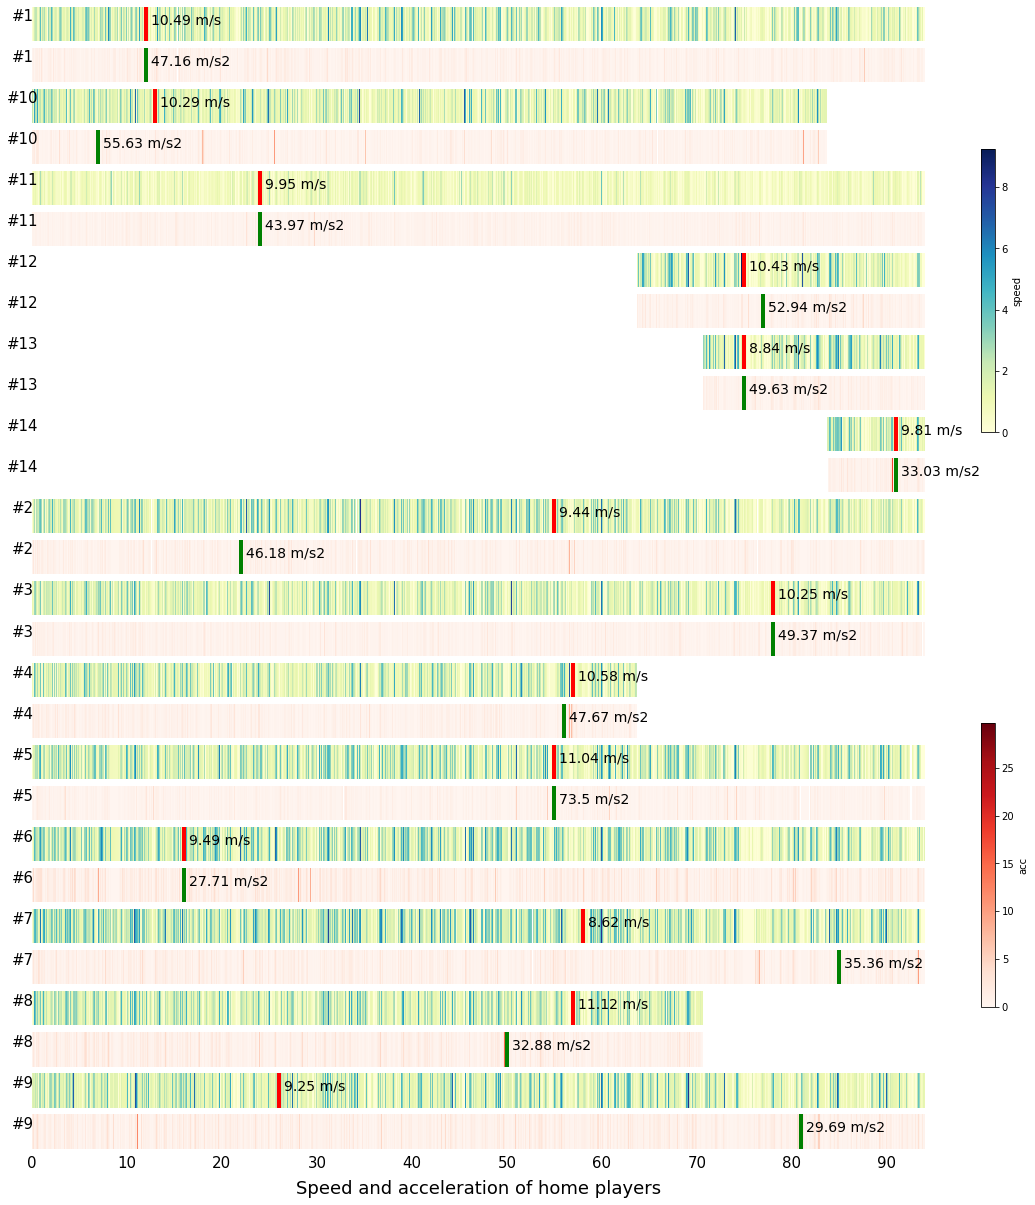

In [575]:
fig, axs = plt.subplots(figsize=(20,0.75*len(cols)), nrows=len(cols), sharex=True)

for i,player_id in enumerate(cols):
    x = hm_data.loc[player_id].index # just frame numbers
    y = hm_data.loc[player_id].values # data values
    t = hm_data.iloc[-1,:].dropna().values # timestamp in mins
    
    if 'acc' in player_id:
        colormap = 'Reds'
        bar = 'green'
        unit = 'm/s2'
    elif 'speed' in player_id:
        colormap = 'YlGnBu'
        bar = 'red'
        unit = 'm/s'
    
    max_val = round(hm_data.loc[player_id].dropna().max(),2)
    max_val_frame = hm_data.loc[player_id].argmax()
    max_val_min = t[hm_data.loc[player_id].argmax()]
    
    extent = [t[0]-(t[1]-t[0])/2., t[-1]+(t[1]-t[0])/2.,0,1]
    im = axs[i].imshow(y[np.newaxis,:], 
                  cmap=colormap, 
                  aspect="auto", 
                  extent=extent)
    if 'acc' in player_id:
        im_acc = im
    elif 'speed' in player_id:
        im_speed = im
    
    
    axs[i].set_ylabel('#'+player_id.split('_')[1], rotation=0, size=15)
    axs[i].yaxis.set_label_coords(-0.01,0.5)
    axs[i].set_yticks([])
    axs[i].set_xlim(extent[0], extent[1])
    axs[i].set_xticks([0,10,20,30,40,50,60,70,80,90])
    axs[i].set_xticklabels(labels = [0,10,20,30,40,50,60,70,80,90],size=15)
    axs[i].tick_params(axis="x", bottom=False)
    axs[i].axvline(x=max_val_min, 
#                    ymin=0.25, ymax=1., 
                   linewidth=4, color=bar)
    # Add labels to the plot
    style = dict(size=14, color='black')

    axs[i].text(max_val_min+0.5, 0.5, "{} {}".format(max_val, unit), **style)
    # axs[0].axis('off')
    sns.despine(left=True, bottom=True, right=True)

cb_speed = fig.colorbar(im_speed, 
                        ax=axs.ravel().tolist()[:14],
                        shrink=0.5)
cb_speed.set_label('speed')
cb_acc = fig.colorbar(im_acc, 
                      ax=axs.ravel().tolist()[14:], 
                      shrink=0.5)
cb_acc.set_label('acc')

plt.title('Speed and acceleration of {} players'.format('home'), size=18, y=-1.5);

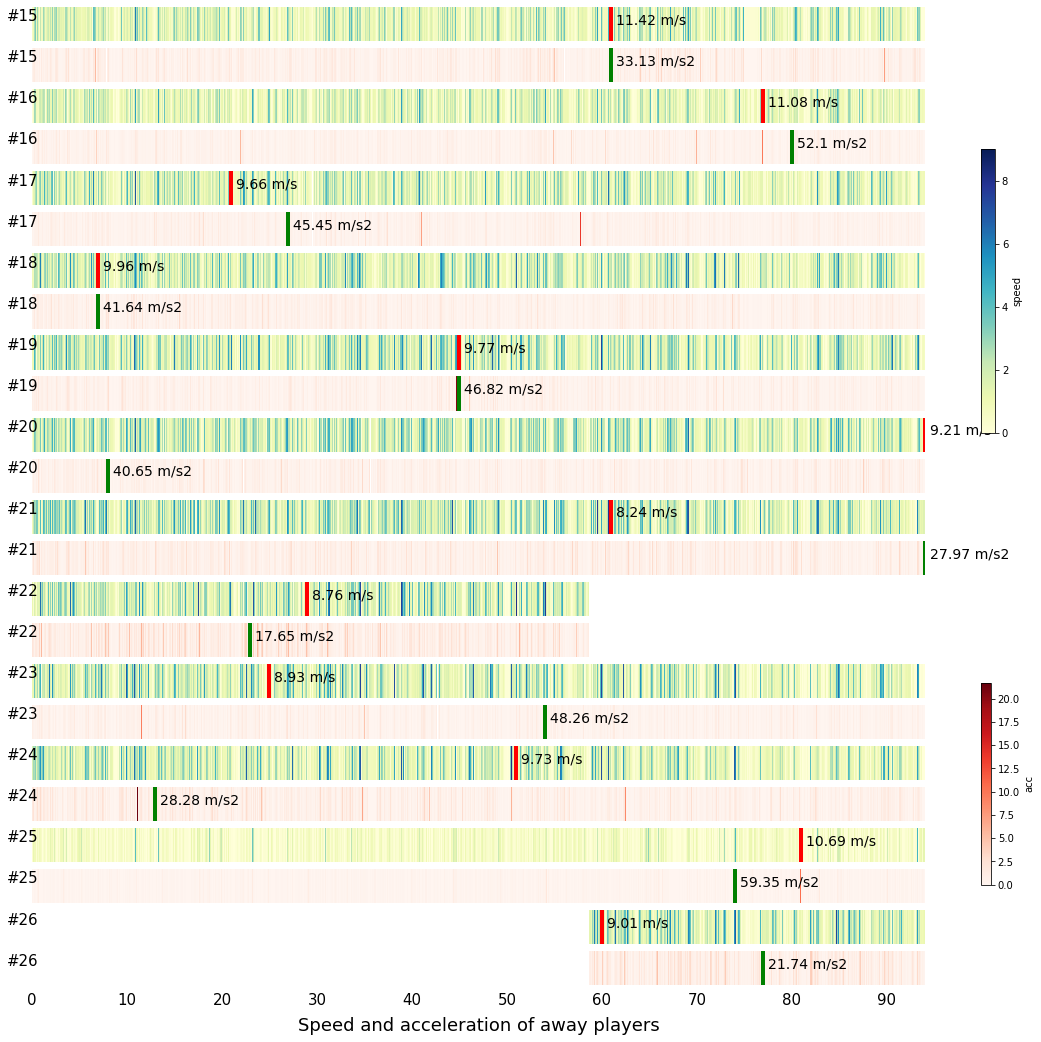

In [576]:
speed_cols = [c for c in tracking_away.columns if 'speed' in c]
acc_cols = [c for c in tracking_away.columns if 'acc' in c]
home_players = [re.findall('\d+',x)[0] for x in speed_cols]
cols = []
for player_num in home_players:
    cols.append([x for x in speed_cols if '_{}_'.format(player_num) in x][0])
    cols.append([x for x in acc_cols if '_{}_'.format(player_num) in x][0])
cols    

hm_data = tracking_away[cols].reset_index()
hm_data['mins'] = round(tracking_away['Time [s]']/60)
hm_data = hm_data.T

fig, axs = plt.subplots(figsize=(20,0.75*len(cols)), nrows=len(cols), sharex=True)

for i,player_id in enumerate(cols):
    x = hm_data.loc[player_id].index # just frame numbers
    y = hm_data.loc[player_id].values # data values
    t = hm_data.iloc[-1,:].dropna().values # timestamp in mins
    
    if 'acc' in player_id:
        colormap = 'Reds'
        bar = 'green'
        unit = 'm/s2'
    elif 'speed' in player_id:
        colormap = 'YlGnBu'
        bar = 'red'
        unit = 'm/s'
    
    max_val = round(hm_data.loc[player_id].dropna().max(),2)
    max_val_frame = hm_data.loc[player_id].argmax()
    max_val_min = t[hm_data.loc[player_id].argmax()]
    
    extent = [t[0]-(t[1]-t[0])/2., t[-1]+(t[1]-t[0])/2.,0,1]
    im = axs[i].imshow(y[np.newaxis,:], 
                  cmap=colormap, 
                  aspect="auto", 
                  extent=extent)
    if 'acc' in player_id:
        im_acc = im
    elif 'speed' in player_id:
        im_speed = im
    
    
    axs[i].set_ylabel('#'+player_id.split('_')[1], rotation=0, size=15)
    axs[i].yaxis.set_label_coords(-0.01,0.5)
    axs[i].set_yticks([])
    axs[i].set_xlim(extent[0], extent[1])
    axs[i].set_xticks([0,10,20,30,40,50,60,70,80,90])
    axs[i].set_xticklabels(labels = [0,10,20,30,40,50,60,70,80,90],size=15)
    axs[i].tick_params(axis="x", bottom=False)
    axs[i].axvline(x=max_val_min, 
#                    ymin=0.25, ymax=1., 
                   linewidth=4, color=bar)
    # Add labels to the plot
    style = dict(size=14, color='black')

    axs[i].text(max_val_min+0.5, 0.5, "{} {}".format(max_val, unit), **style)
    # axs[0].axis('off')
    sns.despine(left=True, bottom=True, right=True)

cb_speed = fig.colorbar(im_speed, 
                        ax=axs.ravel().tolist()[:14],
                        shrink=0.5)
cb_speed.set_label('speed')
cb_acc = fig.colorbar(im_acc, 
                      ax=axs.ravel().tolist()[14:], 
                      shrink=0.5)
cb_acc.set_label('acc')

plt.title('Speed and acceleration of {} players'.format('away'), size=18, y=-1.5);

Home_1_speed
Home_10_speed
Home_11_speed
Home_12_speed
Home_13_speed
Home_14_speed
Home_2_speed
Home_3_speed
Home_4_speed
Home_5_speed
Home_6_speed
Home_7_speed
Home_8_speed
Home_9_speed


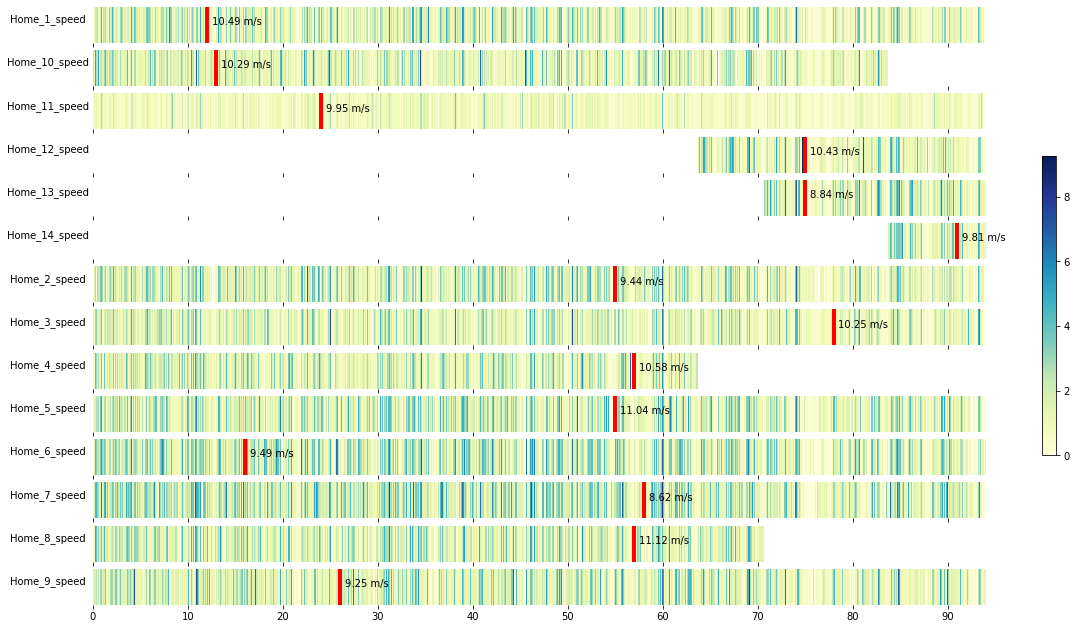

In [503]:

fig, axs = plt.subplots(figsize=(20,1*11), nrows=len(hm_data.index[1:-1]), sharex=True)

for i,player in enumerate(hm_data.index[1:-1]):
    x = hm_data.loc[player].index
    y = hm_data.loc[player].values
    
#     x = hm_data.iloc[i,:].dropna().index#np.linspace(-3,3)
#     y = hm_data.iloc[i,:].dropna().values
    
    t = hm_data.iloc[-1,:].dropna().values
    
    max_speed = round(hm_data.loc[player].dropna().max(),2)
    max_speed_frame = hm_data.loc[player].argmax()
    max_speed_min = t[hm_data.loc[player].argmax()]
    
    print (player)
    
    extent = [t[0]-(t[1]-t[0])/2., t[-1]+(t[1]-t[0])/2.,0,1]
#     print (extent)
    im = axs[i].imshow(y[np.newaxis,:], 
                  cmap="YlGnBu", 
                  aspect="auto", 
                  extent=extent)
    axs[i].set_ylabel(player, rotation=0)
    axs[i].yaxis.set_label_coords(-0.05,0.5)
    axs[i].set_yticks([])
    axs[i].set_xlim(extent[0], extent[1])
    axs[i].set_xticks([0,10,20,30,40,50,60,70,80,90])
    axs[i].axvline(x=max_speed_min, 
#                    ymin=0.25, ymax=1., 
                   linewidth=4, color='r')

    # Add labels to the plot
    style = dict(size=10, color='black')

    axs[i].text(max_speed_min+0.5, 0.5, "{} m/s".format(max_speed), **style)
    # axs[0].axis('off')
    sns.despine(left=True, bottom=True, right=True)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5)

# plt.subplots_adjust(left=0.5, right=0, top=0.9, bottom=0.1)
# plt.tight_layout()


In [302]:
cols = ['Time [s]']+[c for c in tracking_home.columns if 'speed' in c]
hm_data = tracking_home[cols]
hm_data['minute'] = hm_data['Time [s]']/60
hm_data

,Time [s],Home_1_speed,Home_10_speed,Home_11_speed,Home_12_speed,Home_13_speed,Home_14_speed,Home_2_speed,Home_3_speed,Home_4_speed,Home_5_speed,Home_6_speed,Home_7_speed,Home_8_speed,Home_9_speed,minute
Frame,,,,,,,,,,,,,,,,
1,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000667
2,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001333
3,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002000
4,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002667
5,0.20,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,1.563547,0.000000,NaN,NaN,NaN,0.003333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,5646.08,0.0,NaN,0.0,0.0,1.340913,0.967738,0.0,0.0,NaN,0.000000,1.271789,0.0,NaN,1.892280,94.101333
141153,5646.12,0.0,NaN,0.0,0.0,1.311871,1.006439,0.0,0.0,NaN,0.000000,1.050501,0.0,NaN,1.829848,94.102000
141154,5646.16,0.0,NaN,0.0,0.0,1.263686,1.160609,0.0,0.0,NaN,0.000000,0.913685,0.0,NaN,1.819617,94.102667


In [ ]:
num_ticks = 10
# the index of the position of yticks
yticks = np.linspace(0, 100, num_ticks, dtype=np.int)
# the content of labels of these yticks
yticklabels = [depth_list[idx] for idx in yticks]

# then plot the heatmap in this way (where your data is in data):

ax = sns.heatmap(data, yticklabels=yticklabels)
ax.set_yticks(yticks)
plt.show()